## NoteBook for the first project
- Je pensais que l'on pouvait essayer de faire ca comme ceci:
    - Chacun de nous a un block (peut bien entendu en ajouter en dessous du sien) afin de ne pas avoir trop de conflit lorsque l'on git push
        - A tester cette semaine pour voir si c'est ok

# Stefan's Blocks

In [10]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from helpers import *
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# Import csv file

# Import of train.csv
id_train, labels_train, features_train = load_data("train.csv")

# Import of test.csv
id_test, features_test = load_data("test.csv")

In [12]:
# Cell to check if everything is all right for the import
print("To test the load of train.csv:\n")
print(id_train.shape)
print(labels_train)
print(features_train.shape)

print("\nTo test the load of test.csv:\n")
print(id_test.shape)
print(features_test.shape)

To test the load of train.csv:

(250000,)
[ 1 -1 -1 ...,  1 -1 -1]
(250000, 30)

To test the load of test.csv:

(568238,)
(568238, 30)


In [4]:
colors = []
for t in range(labels_train.shape[0]):
    if labels_train[t] == 1:
        colors.append('b')
    else:
        colors.append('r')

In [5]:
j = 0
signal = []
background = []

for i in labels_train:
    if i == 1:
        signal.append(features_train[j,:])
    else:
        background.append(features_train[j,:])
    j = j+1

In [6]:
# Plot one features VS another one
def plotFeatVsFeat(f1,f2):
    plt.figure()
    plt.scatter(features_train[:,f1], features_train[:,f2],color = colors)
    plt.show()

In [7]:
# Find the features that contains at least one times -999.0 and remove this feature
features_to_remove = []
for f in range(features_train.shape[1]):
    if(np.any(features_train[:,f] == -999.0)):
        features_to_remove.append(f)

features_train_good = np.delete(features_train, features_to_remove, axis=1)
print(features_train_good.shape) # In order to see the number of featurer we still have after the deletion (cleaning)

# Separate the samples that are labeled as "sample" and as "background"
j = 0
signal_good_ind = []
background_good_ind = []

for i in labels_train:
    if i == 1:
        signal_good_ind.append(j)
    else:
        background_good_ind.append(j)
    j = j+1

signal_good = features_train_good[signal_good_ind,:]
background_good = features_train_good[background_good_ind,:]
# This was make in order to try to see if one feature give us a good way to separate signal from background

    

(250000, 19)


#### Do a cross validation, using the cleaned data set (=features_train_good)

In [14]:
from cross_val import *
seed = 1
degree = 5
k_fold = 15
lambdas = np.logspace(-6, 1, 40)
# split data in k fold
k_indices = build_k_indices(labels_train, k_fold, seed)
# define lists to store the loss of training data and test data
rmse_tr = []
rmse_te = []
allValidationError = []

for l in lambdas:
    #rmse_tr_l = []
    #rmse_te_l = []
    validation_error = 0
    for k in range(k_fold):
        #rmse_tr_l.append(np.sqrt(2*cross_validation(labels_train, features_train_good, k_indices, k, l, degree)[0]))
        #rmse_te_l.append(np.sqrt(2*cross_validation(labels_train, features_train_good, k_indices, k, l, degree)[1]))
        validation_error = validation_error + cross_validation(labels_train, features_train_good, k_indices, k, l, degree) # DElete the degree!
    allValidationError.append(validation_error/k_fold) # we compute the mean of the validation error
    #rmse_tr.append(np.mean(rmse_tr_l))
    #rmse_te.append(np.mean(rmse_te_l))
    
#cross_validation_visualization(lambdas, rmse_tr, rmse_te)


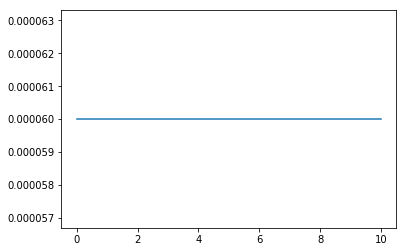

In [15]:
plt.close("all")
plt.plot(lambdas, allValidationError)
plt.show()

0


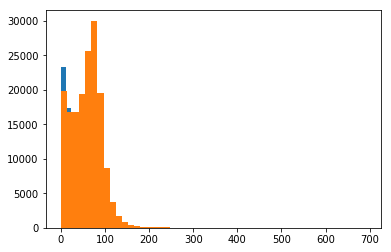

2


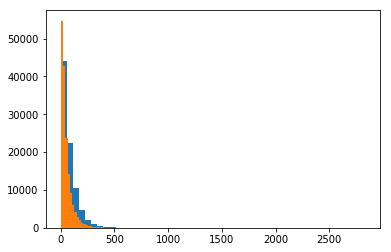

5


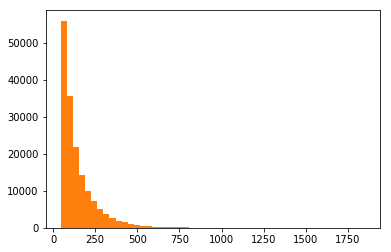

8


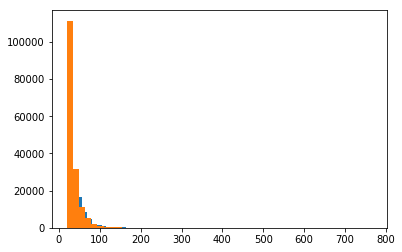

16


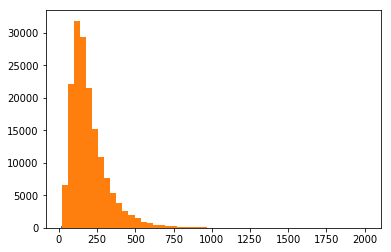

18


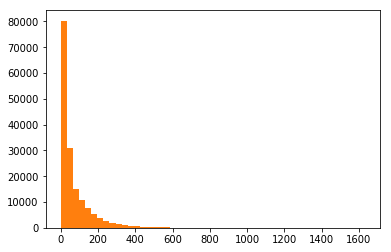

In [42]:
# Just to learn some stuff about the data 
mean_feat_signal = []
mean_feat_back = []
std_feat_signal = []
std_feat_back = []
diff_mean =[]

for i in range(features_train_good.shape[1]):
    mean_feat_signal.append(np.mean(signal_good[:,i]))
    mean_feat_back.append(np.mean(background_good[:,i]))
    
    std_feat_signal.append(np.std(signal_good[:,i]))
    std_feat_back.append(np.std(background_good[:,i]))

for index_mean, m in enumerate(mean_feat_signal):
    diff_mean.append(abs(m - mean_feat_back[index_mean] ))


mean_thediff = np.mean(diff_mean)
ind_featInterest = np.where(diff_mean >= mean_thediff)
features_interst = features_train_good[:,np.where(diff_mean >= mean_thediff)[0]]

for ind in ind_featInterest[0]:
    print(ind)
    plt.figure()
    plt.hist(signal_good[:,ind],50)
    plt.hist(background_good[:,ind],50)
    plt.show()

    
    
    
    

In [ ]:
# To compute the losse, with mse --> with solution
def compute_mse(y, tx, w):
    """Calculate the loss.

    You can calculate the loss using mse or mae.
    """
    """compute the loss by mse."""
    e = y - tx.dot(w)
    mse = e.dot(e) / (2 * len(e)) # Here if we have any problem we should try with 
    return mse

In [ ]:
# Gradient descent

def compute_gradient(y, tx, w):
    """Compute the gradient."""

    # compute gradient and loss
    e = y - np.dot(tx, w)
    gradient = -1/len(y) * np.dot(tx.T, e)
    
    loss = compute_mse(y,tx,w)
    return gradient, loss


def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # compute gradient and loss
        gradient, loss = compute_gradient(y,tx,w)

        # update w by gradient
        w = ws[n_iter] - gamma*gradient
        
        # store w and loss
        ws.append(w)
        losses.append(loss)
        
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses[-1], ws[-1,:]

In [ ]:
# Stochastic gradient descent
def batch_iter(y, tx, batch_size, num_batches=1, shuffle=True):
    """
    Generate a minibatch iterator for a dataset.
    Takes as input two iterables (here the output desired values 'y' and the input data 'tx')
    Outputs an iterator which gives mini-batches of `batch_size` matching elements from `y` and `tx`.
    Data can be randomly shuffled to avoid ordering in the original data messing with the randomness of the minibatches.
    Example of use :
    for minibatch_y, minibatch_tx in batch_iter(y, tx, 32):
        <DO-SOMETHING>
    """
    data_size = len(y)

    if shuffle:
        shuffle_indices = np.random.permutation(np.arange(data_size))
        shuffled_y = y[shuffle_indices]
        shuffled_tx = tx[shuffle_indices]
    else:
        shuffled_y = y
        shuffled_tx = tx
    for batch_num in range(num_batches):
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1) * batch_size, data_size)
        if start_index != end_index:
            yield shuffled_y[start_index:end_index], shuffled_tx[start_index:end_index]
            

def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient from just few examples n and their corresponding y_n labels."""
    e = y - np.dot(tx, w)
    gradient = -1/len(y) * np.dot(tx.T, e)
    
    loss = compute_loss(y,tx,w)
    return gradient, loss


def stochastic_gradient_descent(y, tx, initial_w, max_iters, gamma, batch_size=1):
    """Stochastic gradient descent algorithm."""
    ws = [initial_w]
    losses = []
    lossForOneRun = 0
    
    for n_iters in range(max_iters):
        for minibatch_y, minibatch_tx in batch_iter(y, tx, batch_size):
            gradient, loss = compute_stoch_gradient(minibatch_y, minibatch_tx, ws[n_iters])
            lossForOneRun = lossForOneRun + loss
            w = ws[n_iters] - gamma*gradient
        
        losses.append((1/batch_size)*lossForOneRun)
        ws.append(w)
    
    return losses[-1], ws[-1,:]

In [ ]:
# Least squares --> With solution
def least_squares(y, tx):
    """calculate the least squares solution."""
    
    a = tx.T.dot(tx)
    b = tx.T.dot(y)
    w = np.linalg.solve(a, b)
    loss = compute_mse(y, tx, w)
    
    return w, loss


In [ ]:
# Ridge_regression using normal equations --> with solution
def ridge_regression(y, tx, lambda_):
    """implement ridge regression."""

    aI = 2 * tx.shape[0] * lambda_*np.identity(tx.shape[1])
    a = tx.T.dot(tx) + aI
    b = tx.T.dot(y)
    
    w = np.linalg.solve(a,b)
    loss = compute_mse(y, tx, w)
    
    return w, loss

# Etienne's Blocks

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from helpers import *
%load_ext autoreload
%autoreload 2


In [2]:
trainData = pd.read_csv("train.csv")
testData = pd.read_csv("test.csv")
display(trainData.head(5))
display(testData.head(5))

,Id,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,100000,s,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,...,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497
1,100001,b,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,...,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226
2,100002,b,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,...,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251
3,100003,b,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,...,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000
4,100004,b,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,...,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000


,Id,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,350000,?,-999.000,79.589,23.916,3.036,-999.000,-999.000,-999.000,0.903,...,2.022,98.556,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
1,350001,?,106.398,67.490,87.949,49.994,-999.000,-999.000,-999.000,2.048,...,-1.138,176.251,1,47.575,-0.553,-0.849,-999.000,-999.000,-999.000,47.575
2,350002,?,117.794,56.226,96.358,4.137,-999.000,-999.000,-999.000,2.755,...,-1.868,111.505,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
3,350003,?,135.861,30.604,97.288,9.104,-999.000,-999.000,-999.000,2.811,...,1.172,164.707,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
4,350004,?,74.159,82.772,58.731,89.646,1.347,536.663,-0.339,1.028,...,-0.231,869.614,3,254.085,-1.013,-0.334,185.857,0.335,2.587,599.213


# Ivan's Blocks

In [ ]:
# First block for Ivan
print('Salut kikoo')

In [ ]:
import numpy as np

In [ ]:
print('encore une modification')